# 第一部分 课程内容

* 教学目的
    这一节我们将学习的是，ARIMA模型，全称差分整合移动平均自回归模型，时间序列预测分析方法之一。我们将从简介绍如何用python来实现他们。
    我们将逐步介绍ARIMA模型的三个阶段，MA，ARMA以及ARIMA。ARIMA(p,d,q)模型，其中d是差分的阶数，用来得到平稳序列。AR是自回归, p为相应的自回归项。MA为移动平均，q为相应的移动平均项数。
    最终得到的ARIMA模型可以表达为：
    $$
    \left(1 - \sum_{i=1}^p \phi_i L^i\right) (1-L)^d X_t = \left(1 + \sum_{i=1}^q \theta_i L^i\right) \varepsilon_t\
    $$
    其中$L$是滞后算子（Lag operator），$d \in \mathbb{Z}$, $d>0$。  
    
    同时，你将学习用到前面分析基础的知识，这对于开始用python解决实际问题而言只是开始，但是并不简单，所以我们在教程里会引导你，给你作出表率。
    
* 教学材料

    我们使用上证指数的日涨跌数据（2013年1月至2014年8月）来进行分析。
    
    我们将用到绘图包matplotlib，数据分析基础包scipy、numpy和pandas，统计知识的包statsmodels和scipy。

## 1 滑动平均(MA)模型

这里我们直接给出MA(q)模型的形式： $$ \large r_t = c_0 + a_t - \theta_1a_{t-1} - \cdots - \theta_qa_{t-q}$$

$c_0$为一个常数项。这里的$a_t$,是AR模型$t$时刻的扰动或者说信息，则可以发现，该模型使用了**过去q个时期的随机干扰或预测误差来线性表达当前的预测值**。

### 1.1 MA模型的性质

1. 平稳性

    **MA模型总是弱平稳的**，因为他们是白噪声序列（残差序列）的有限线性组合。因此，根据弱平稳的性质可以得出两个结论：
    $$\large E(r_t) = c_0 \large Var(r_t) = (1+ \theta_1^2 + \theta_2^2 + \cdots +\theta_q^2)\sigma_a^2$$ 
    
2. 自相关函数
    
    对q阶的MA模型，其自相关函数ACF总是**q步截尾**的。 因此MA(q)序列只与其前q个延迟值线性相关，从而它是一个“**有限记忆**”的模型。这一点可以用来确定模型的阶次，后面会介绍。
    
3. 可逆性
    当满足**可逆条件**的时候，MA(q)模型可以改写为AR(p)模型。这里不进行推导，给出1阶和2阶MA的可逆性条件。

    1阶：$ \large |\theta_1|< 1$

    2阶： $ \large |\theta_2| < 1, \theta_1 + \theta_2 < 1$
    

### 1.2 MA的阶次判定

我们通常利用上面介绍的第二条性质：MA(q)模型的ACF函数q步截尾来判断模型阶次。示例如下：

使用上证指数的日涨跌数据（2013年1月至2014年8月）来进行分析，首先取得数据：

In [1]:
# 统计相关的库
from scipy import  stats
import statsmodels.api as sm  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 忽略warning级别的报警
import warnings
# warnings.filterwarnings('ignore')

从我们的数据目录中读取数据，这里已经准备好了。然后我们把涨跌幅画出来看看。

             tradeDate  closeIndex    CHGPct
tradeDate                                   
2013-01-04  2013-01-04    2276.992  0.003466
2013-01-07  2013-01-07    2285.364  0.003677
2013-01-08  2013-01-08    2276.070 -0.004067
2013-01-09  2013-01-09    2275.340 -0.000321
2013-01-10  2013-01-10    2283.658  0.003656


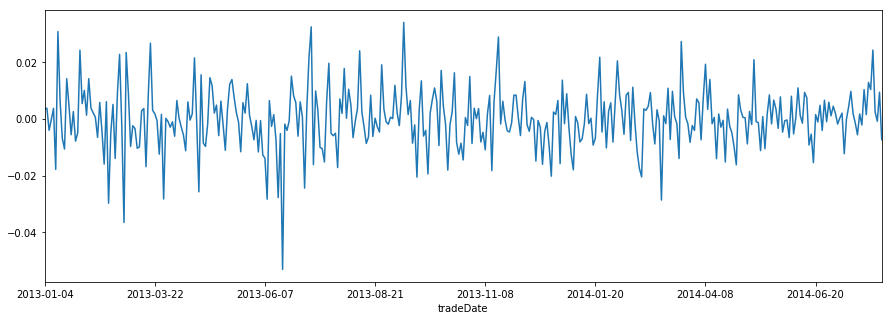

In [2]:
IndexData = pd.read_csv('../data/上证指数201301.csv')
IndexData = IndexData.set_index(IndexData['tradeDate'])
print(IndexData.head())

# 查看涨跌幅 
data = np.array(IndexData['CHGPct'])
IndexData['CHGPct'].plot(figsize=(15,5))

可以看出，序列看上去是弱平稳的。

下面我们画出序列的ACF：

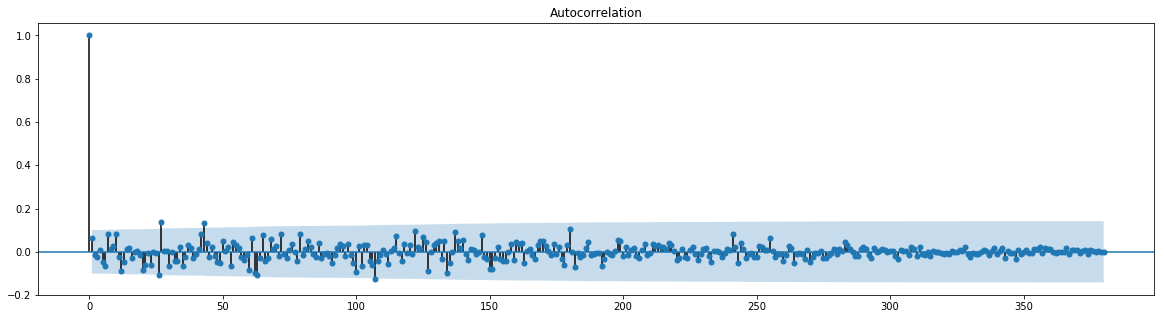

In [3]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(data,ax=ax1)

我们发现ACF函数在43处截尾，之后的acf函数均在置信区间内，我们判定该序列MA模型阶次为43阶。

### 1.3 建模和预测

虽然sm.tsa中没有单独的MA模块，但是我们通过已经知道的ARMA和MA的关系，可以利用ARMA模块来替代MA，只要将其中AR的阶p设为0即可。

函数sm.tsa.ARMA中的输入参数中的order(p,q)，代表了AR和MA的阶次。由于模型阶次增高，计算量急剧增长，这里就建立10阶的模型作为示例，如果按上一节的判断阶次来建模，计算时间过长。

我们用最后10个数据作为out-sample的样本，用来对比预测值。

In [4]:
order = (0,10)
train = data[:-10]
test = data[-10:]
tempModel = sm.tsa.ARMA(train,order).fit()

我们先来看看拟合效果,计算 
$$ \large Adj R^2 = 1- \frac{残差的平方}{r_t的方差} $$

In [5]:
delta = tempModel.fittedvalues - train
score = 1 - delta.var()/train.var()
score

0.02787399762457965

可以看出，score远小于1，拟合效果不好。

然后我们用建立的模型进行预测最后10个数据

10


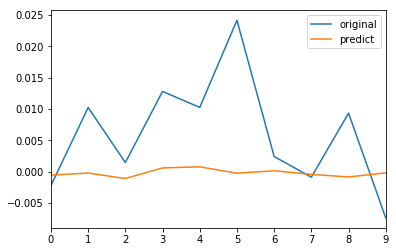

In [5]:
predicts = tempModel.predict(371, 380, dynamic=True)
print(len(predicts))
comp = pd.DataFrame()
comp['original'] = test
comp['predict'] = predicts
comp.plot()

可以看出，建立的模型效果很差，预测值明显小了1到2个数量级！就算只看涨跌方向，正确率也不足50%。该模型不适用于原数据。

没关系，如果真的这么简单能预测指数日涨跌才奇怪了，MA本来就是比较粗糙的模型，下面的模型会在他的基础上进行修改优化，达到更好的效果。

## 2 ARMA模型

在有些应用中，我们需要高阶的AR或MA模型才能充分地描述数据的动态结构，这样问题会变得很繁琐。为了克服这个困难，提出了自回归滑动平均(ARMA)模型。其基本思想是把AR和MA模型结合在一起，使所使用的参数个数保持很小。

模型的形式为：

$$ \large r_t = \phi_0 + \sum_{i=1}^p\phi_ir_{t-i} + a_t + \sum_{i=1}^q\theta_ia_{t-i} $$

其中，{$a_t$}为白噪声序列，$p$和$q$都是非负整数。**AR和MA模型都是ARMA(p,q)的特殊形式**。

利用向后推移算子$B$，上述模型可写成: 

$$ \large (1-\phi_1B - \cdots -\phi_pB^p)r_t = \phi_0 + (1-\theta_1B-\cdots - \theta_qB^q)a_t$$

后移算子$B$，代表了**上一时刻**。

这时候我们求$r_t$的期望，得到：

$$ \large E(r_t) = \frac{\phi_0}{1-\phi_1-\cdots - \phi_p}$$

和上期我们的AR模型一模一样。因此有着相同的特征方程：

$$\large 1 - \phi_1x - \phi_2x^2 - \cdots -\phi_px^p = 0$$

该方程所有解的倒数称为该模型的**特征根**，如果所有的特征根的模都小于1，则该ARMA模型是平稳的。

有一点很关键：ARMA模型的应用对象应该为平稳序列！我们下面的步骤都是建立在假设原序列平稳的条件下的。

### 2.1 识别ARMA模型阶次

我们通过观察PACF和ACF截尾，分别判断p、q的值。(限定滞后阶数50)

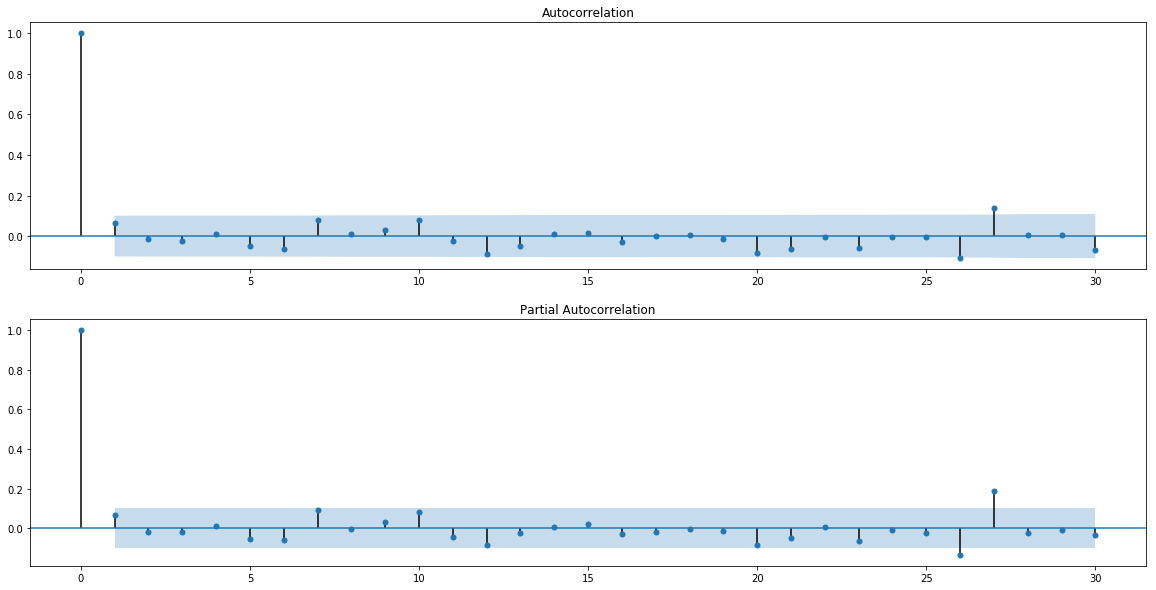

In [23]:
fig = plt.figure(figsize=(20,10))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data,lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data,lags=30,ax=ax2)

可以看出，模型的阶次应该为(27,27)。然而，这么高的阶次建模的计算量是巨大的。

为什么不再限制滞后阶数小一些？如果lags设置为25，20或者更小时，阶数为(0,0)，显然不是我们想要的结果。

综合来看，由于计算量太大，在这里就不使用(27,27)建模了。采用另外一种方法确定阶数。

### 2.2 信息准则定阶

目前选择模型常用如下准则： （其中L为似然函数，k为参数数量，n为观察数）

* AIC=-2ln(L)+2k 中文名字：赤池信息量 akaike information criterion

* BIC=-2ln(L)+ln(n)\*k 中文名字：贝叶斯信息量 bayesian information criterion

* HQ=-2ln(L)+ln(ln(n))\*k hannan-quinn criterion

我们常用的是AIC准则，AIC鼓励数据拟合的优良性但是尽量避免出现过度拟合(Overfitting)的情况。所以优先考虑的模型应是AIC值最小的那一个模型。

下面，我们分别应用以上3种法则，为我们的模型定阶，数据仍然是上证指数日涨跌幅序列：

为了控制计算量，我们限制AR最大阶不超过6，MA最大阶不超过4。但是这样带来的坏处是可能为局部最优。

注意下面的运算可能需要大量时间，请耐心等待。

In [21]:
sm.tsa.arma_order_select_ic(data,max_ar=6,max_ma=4,ic='aic')[('aic_min_order')]  # AIC

/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site

(3, 3)

In [10]:
sm.tsa.arma_order_select_ic(data,max_ar=6,max_ma=4,ic='bic')['bic_min_order']  # BIC

(0, 0)

In [12]:
sm.tsa.arma_order_select_ic(data,max_ar=6,max_ma=4,ic='hqic')['hqic_min_order'] # HQIC

(0, 0)

可以看出，AIC求解的模型阶次为(3,3)。我们这里就以AIC准则为准。至于到底哪种准则更好，同学们可以分别建模进行对比。

## 2.2 模型的建立及预测

我们使用AIC准则求解的模型阶次(3,3)来建立ARMA模型，源数据为上证指数日涨跌幅数据，最后10个数据用于预测。

In [38]:
# todo
order = (3,3)
train = data[:-10]
test = data[-10:]
# import statsmodels
tempModel = sm.tsa.ARMA(train, order).fit()
tempModel.fittedvalues
tempModel.aic

/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


nan

同样的，先来看看拟合效果：

In [30]:
delta = tempModel.fittedvalues - train
score = 1 - delta.var()/train.var()
score

nan

如果对比之前建立的AR、MA模型，可以发现拟合精度上有所提升，但效果仍然不是很好。

接着来看预测效果：

10


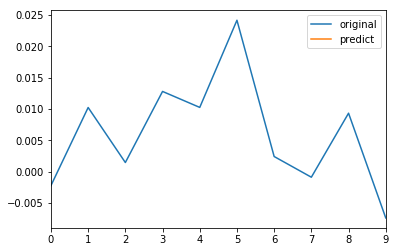

In [40]:
predicts = tempModel.predict(371, 380, dynamic=True)
print(len(predicts))
comp = pd.DataFrame()
comp['original'] = test
comp['predict'] = predicts
comp.plot()

可以看出，虽然误差不小，不过相比之前的MA模型，只看涨跌的话，准确率为55.6%，效果还是好了不少。

## 3 ARIMA模型

到目前为止，我们研究的序列都集中在平稳序列。即ARMA模型研究的对象为平稳序列。如果序列是非平稳的，就可以考虑使用ARIMA模型。

ARIMA比ARMA仅多了个"I"，代表着其比ARMA多一层内涵：也就是**差分**。

一个非平稳序列经过d次差分后，可以转化为平稳时间序列。d具体的取值，我们得分被对差分1次后的序列进行平稳性检验，若果是非平稳的，则继续差分。直到d次后检验为平稳序列。这样的思想很巧妙，但是操作却十分简单。

### 3.1 单位根检验

ADF是一种常用的单位根检验方法，它的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。

下面给出示例：我们先看上证综指的日指数序列：

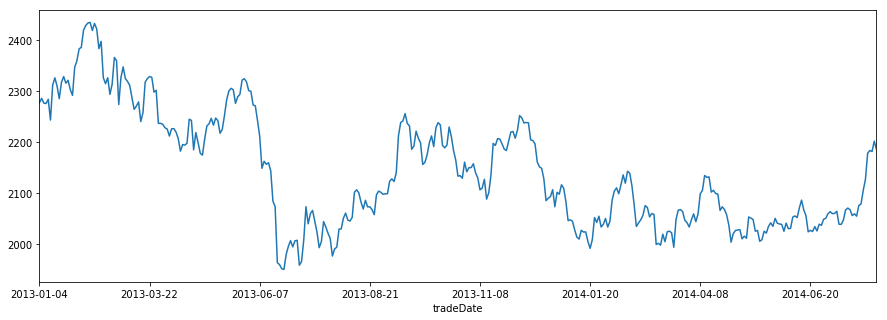

In [41]:
data2 = IndexData['closeIndex'] # 上证指数
data2.plot(figsize=(15,5))

看图形，这里显然是非平稳的。接着我们进行ADF单位根检验。

In [42]:
temp = np.array(data2)
t = sm.tsa.stattools.adfuller(temp)  # ADF检验
output=pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],columns=['value'])
output['value']['Test Statistic Value'] = t[0]
output['value']['p-value'] = t[1]
output['value']['Lags Used'] = t[2]
output['value']['Number of Observations Used'] = t[3]
output['value']['Critical Value(1%)'] = t[4]['1%']
output['value']['Critical Value(5%)'] = t[4]['5%']
output['value']['Critical Value(10%)'] = t[4]['10%']
output

,value
Test Statistic Value,-2.30472
p-value,0.170449
Lags Used,1
Number of Observations Used,379
Critical Value(1%),-3.44772
Critical Value(5%),-2.8692
Critical Value(10%),-2.57085


可以看出，p-value为0.170449，大于显著性水平。原假设：序列具有单位根即非平稳。不能被拒绝。因此上证指数日指数序列为非平稳的。

我们将序列进行1次差分后再次检验！

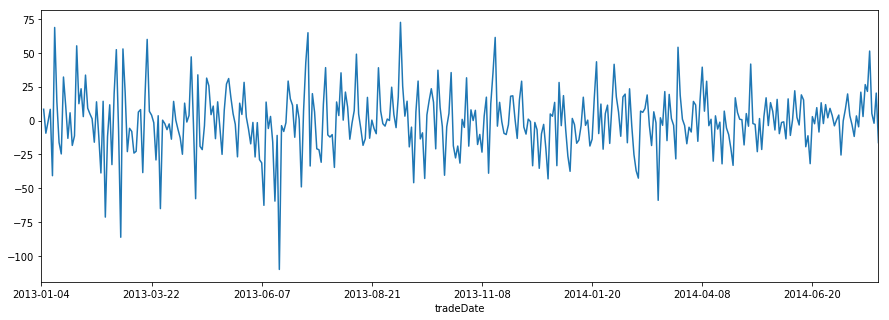

In [43]:
data2Diff = data2.diff()  # 差分
data2Diff.plot(figsize=(15,5))

从图形来看，序列近似平稳序列，我们来进行ADF检验：

In [47]:
temp = np.array(data2Diff)[1:] # 差分后第一个值为NaN,舍去
t = sm.tsa.stattools.adfuller(temp)  # ADF检验
print("p-value:   ",t[1],temp)

p-value:    2.3124575014426317e-30 [ 8.3720e+00 -9.2940e+00 -7.3000e-01  8.3180e+00 -4.0661e+01  6.8743e+01
  1.3942e+01 -1.6183e+01 -2.4590e+01  3.2161e+01  1.1151e+01 -1.3082e+01
  5.7720e+00 -1.8313e+01 -1.1294e+01  5.5201e+01  1.2472e+01  2.3498e+01
  2.9470e+00  3.3598e+01  9.1340e+00  4.9760e+00  1.3470e+00 -1.5947e+01
  1.3872e+01 -1.0844e+01 -3.8644e+01  1.4264e+01 -7.1227e+01 -1.1787e+01
  1.1655e+01 -3.2478e+01  1.9879e+01  5.2373e+01 -6.0870e+00 -8.6102e+01
  5.2902e+01  2.0873e+01 -2.2886e+01 -5.6820e+00 -8.0180e+00 -2.3988e+01
 -2.2637e+01  6.3090e+00  8.1240e+00 -3.8385e+01  1.7418e+01  5.9940e+01
  6.8680e+00  4.0360e+00 -1.5630e+00 -2.9046e+01  3.5900e+00 -6.4957e+01
  3.1900e-01 -2.2260e+00 -6.6550e+00 -2.4450e+00 -1.3703e+01  1.4183e+01
  3.5100e-01 -6.5730e+00 -1.2773e+01 -2.4838e+01  1.2904e+01 -1.0500e+00
  3.8060e+00  4.7041e+01 -2.4740e+00 -5.7631e+01  3.3780e+01 -1.9011e+01
 -2.1395e+01 -3.7890e+00  3.1374e+01  2.5669e+01  4.4090e+00  1.0725e+01
 -1.3329e+01  1.

可以看出，p-value非常接近于0，拒绝原假设，因此，该序列为平稳的。 

可见，经过1次差分后的序列是平稳的，对于原序列，**d的取值为1即可**。

## 3.2 ARIMA(p,d,q)模型阶次确定

上面一小节我们确定了差分次数d，接下来，我们就可以将差分后的序列建立ARMA模型。首先，我们还是尝试PACF和ACF来判断p、q。

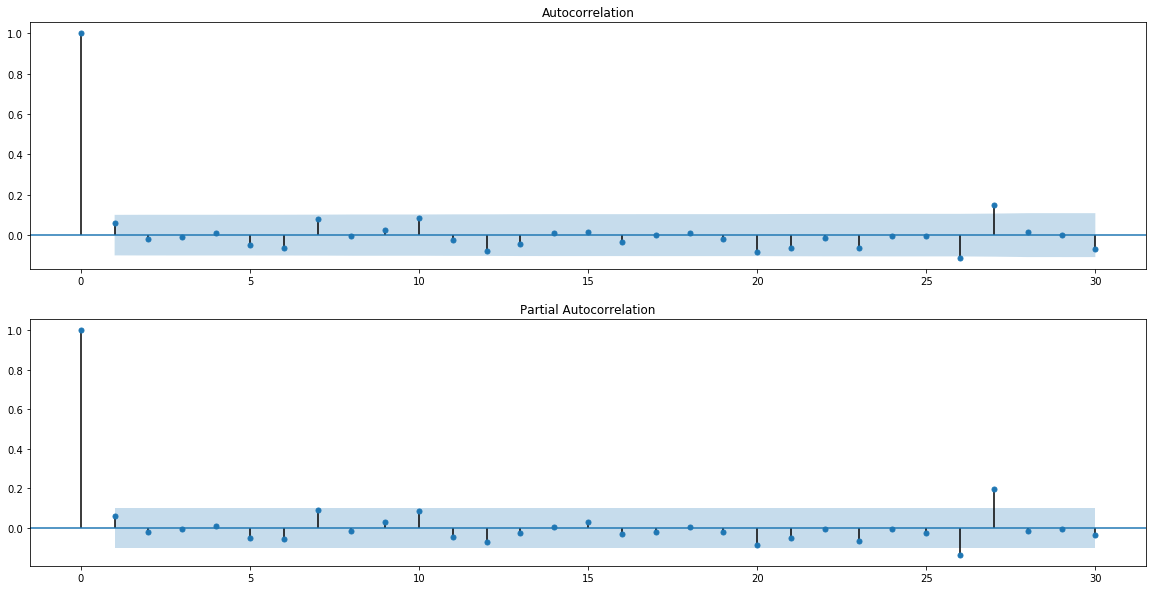

In [45]:
temp = np.array(data2Diff)[1:] # 差分后第一个值为NaN,舍去
fig = plt.figure(figsize=(20,10))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp,lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp,lags=30,ax=ax2)

可以看出，模型的阶次为(27,27)，还是太高了。建模计算了太大。我们再看看AIC准则

In [63]:
# todo 3,3
print(temp)
sm.tsa.arma_order_select_ic(temp,max_ar=6,max_ma=4,ic='aic')['aic_min_order']  # AIC

[ 8.3720e+00 -9.2940e+00 -7.3000e-01  8.3180e+00 -4.0661e+01  6.8743e+01
  1.3942e+01 -1.6183e+01 -2.4590e+01  3.2161e+01  1.1151e+01 -1.3082e+01
  5.7720e+00 -1.8313e+01 -1.1294e+01  5.5201e+01  1.2472e+01  2.3498e+01
  2.9470e+00  3.3598e+01  9.1340e+00  4.9760e+00  1.3470e+00 -1.5947e+01
  1.3872e+01 -1.0844e+01 -3.8644e+01  1.4264e+01 -7.1227e+01 -1.1787e+01
  1.1655e+01 -3.2478e+01  1.9879e+01  5.2373e+01 -6.0870e+00 -8.6102e+01
  5.2902e+01  2.0873e+01 -2.2886e+01 -5.6820e+00 -8.0180e+00 -2.3988e+01
 -2.2637e+01  6.3090e+00  8.1240e+00 -3.8385e+01  1.7418e+01  5.9940e+01
  6.8680e+00  4.0360e+00 -1.5630e+00 -2.9046e+01  3.5900e+00 -6.4957e+01
  3.1900e-01 -2.2260e+00 -6.6550e+00 -2.4450e+00 -1.3703e+01  1.4183e+01
  3.5100e-01 -6.5730e+00 -1.2773e+01 -2.4838e+01  1.2904e+01 -1.0500e+00
  3.8060e+00  4.7041e+01 -2.4740e+00 -5.7631e+01  3.3780e+01 -1.9011e+01
 -2.1395e+01 -3.7890e+00  3.1374e+01  2.5669e+01  4.4090e+00  1.0725e+01
 -1.3329e+01  1.3860e+01 -4.9110e+00 -2.4910e+01  7

/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/srv/conda/lib/python3.7/site-packages/s

(3, 3)

todo  
根据AIC准则，差分后的序列的ARMA模型阶次为(3,3)。因此，我们要建立的ARIMA模型阶次(p,d,q) = (2,1,2)

### 3.3 ARIMA模型建立及预测

根据上一结确定的模型阶次，我们对差分后序列建立ARMA(2,2)模型：

In [62]:
order = (2,2)
data = np.array(data2Diff)[1:] # 差分后，第一个值为NaN
rawdata = np.array(data2)
train = data[:-10]
test = data[-10:]
model = sm.tsa.ARMA(train,order).fit()

我们先看差分序列的ARMA拟合值。

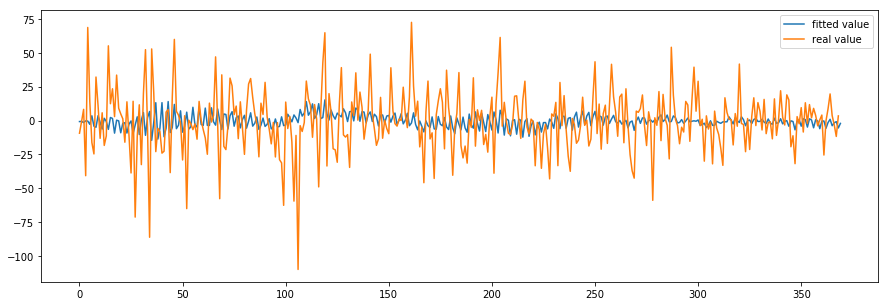

In [57]:
plt.figure(figsize=(15,5))
plt.plot(model.fittedvalues,label='fitted value')
plt.plot(train[1:],label='real value')
plt.legend(loc=0)

In [58]:
delta = model.fittedvalues - train
score = 1 - delta.var()/train[1:].var()
print(score)

0.052851840334258715


再看对差分序列的预测情况：

10


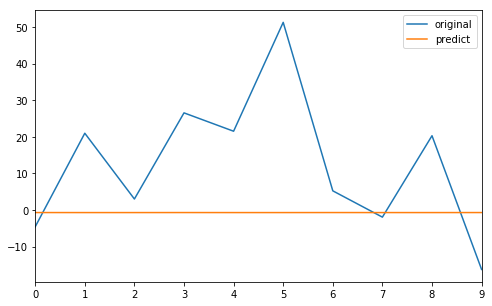

In [59]:
predicts = model.predict(10,381, dynamic=True)[-10:]
print(len(predicts))
comp = pd.DataFrame()
comp['original'] = test
comp['predict'] = predicts
comp.plot(figsize=(8,5))

可以看出，差分序列ARMA模型的拟合效果和预测结果并不好，预测值非常小，这代表对于新的值，这里认为它很接近上一时刻的值。

这个影响可能来自模型阶次，有兴趣的同学可以试试高阶的模型，看看情况会不会有所改观。

然后我们将预测值还原（即在上一时刻指数值的基础上加上差分差值的预估）：

In [61]:
rec = [rawdata[-11]]
pre = model.predict(371, 380, dynamic=True) # 差分序列的预测
for i in range(10):
    rec.append(rec[i]+pre[i])

ValueError: could not broadcast input array from shape (2) into shape (3)

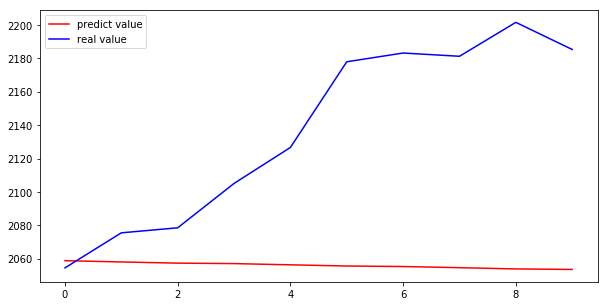

In [55]:
plt.figure(figsize=(10,5))
plt.plot(rec[-10:],'r',label='predict value')
plt.plot(rawdata[-10:],'blue',label='real value')    
plt.legend(loc=0)

我们发现，由于对差分序列的预测很差，还原到原序列后，预测值几乎在预测前一个值上小幅波动。仍然是模型不够好。

这一次的实验结果并不是很好，不过结果并不重要，方法已经被验证了才重要，剩下的只是对已有的模型的优化，比如提高模型的阶次或者增加新的参数，这样会导致运行时间显著增长。

## 4 总结

目前为止，我们接触的模型其实核心就是ARMA模型，其他模型都是其特殊形式。现存的模型，对指数日涨跌序列或者指数日序列的预测都没有特别好的效果。这也很容易理解，除开预测市场的本身难度以外，一旦有效的预测机制出现，则会被运用到市场中，然后市场会迅速地自动调节，反过来降低了预测准确度。

而对于建模方面，这类模型的阶次确立以及建立高阶模型是主要难点。

# 第二部分 课程练习

1. 请对气温、房价或者油价进行时间序列分析
2. 请按照文中的提示，提高阶次进行分析，这可能需要长得多的运行时间

# 第三部分 延伸学习

由于容量问题，很多东西是没有办法介绍的，下面给出一些延伸学习的主题，请自行学习。
1. 下一个教程我们将介绍ARCH模型，请先了解
2. 不仅是金融领域，数据分析涉及到了生活各方各面，请到kaggle看看大家都在做什么，比如，这里有游客数量分析的[数据](https://www.kaggle.com/shaclo/retail)
3. 模型的修改和优化是科学家和工程师们的工作重点之一，请自行推导MA，ARMA，ARIMA模型的数学公式